In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import librosa
import librosa.display

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import pyprojroot
from pyprojroot.here import here

import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

#Load raw data

In [2]:

def load_raw_data():
    """ This method reads in the raw data file and retruns the cleaned raw data"""
    # reading in the data
    base_path = pyprojroot.find_root(pyprojroot.has_dir("notebooks"))
    data = pd.read_csv(here("data/raw/train.csv"))

    # mapping primary - scientific - common labels
    mapped = data[["primary_label", "scientific_name", "common_name"]]
    mapped = mapped.drop_duplicates()

    #species reference to obtain class label
    spec_dat = pd.read_csv(here("data/raw/taxonomy.csv"))
    # taking out the taxon_id since it's duplicated
    spec_dat = spec_dat.drop("inat_taxon_id", axis = 1)

    # merging class_name
    full_data = pd.merge(data, spec_dat, on = ["primary_label", "scientific_name", "common_name"], how = "left")
    full_data.head()


    full_data = full_data.replace(to_replace=r"\[''\]", value=pd.NA, regex=True)


    return full_data

In [3]:
birdclef_df = load_raw_data()

species_counts = birdclef_df["primary_label"].value_counts()
print(f"{list(species_counts.index)[0]} Species has highest samples count :  ", max(species_counts) , 
      f"\n{list(species_counts.index)[-1]} Species has lowest samples count : ", min(species_counts))

top_species = list((species_counts[species_counts > 500]).index)
top_species_class = np.unique(list(birdclef_df[birdclef_df["primary_label"].isin(top_species)]["class_name"]))
print("top_species_class", top_species_class)



grekis Species has highest samples count :   990 
1139490 Species has lowest samples count :  2
top_species_class ['Aves']


In [4]:
## Load in spectrograph data and labels
#data=np.load(here('data/processed/debug_birdclef2025_melspec_5sec_256_256.npy'),allow_pickle=True)
data=np.load(here('data/processed/birdclef2025_melspec_5sec_256_256.npy'),allow_pickle=True)
graph_dict=data.item()
labels=pd.read_csv(here('data/raw/taxonomy.csv'))
count = len(graph_dict.keys())
print('count', count)
i=0
for key, array in graph_dict.items():
    while i < 10:
        print(f'Key: {key}, Shape: {array.shape}, Dtype: {array.dtype}')
        i += 1

count 28564
Key: 1139490-CSA36385, Shape: (256, 256), Dtype: float32
Key: 1139490-CSA36385, Shape: (256, 256), Dtype: float32
Key: 1139490-CSA36385, Shape: (256, 256), Dtype: float32
Key: 1139490-CSA36385, Shape: (256, 256), Dtype: float32
Key: 1139490-CSA36385, Shape: (256, 256), Dtype: float32
Key: 1139490-CSA36385, Shape: (256, 256), Dtype: float32
Key: 1139490-CSA36385, Shape: (256, 256), Dtype: float32
Key: 1139490-CSA36385, Shape: (256, 256), Dtype: float32
Key: 1139490-CSA36385, Shape: (256, 256), Dtype: float32
Key: 1139490-CSA36385, Shape: (256, 256), Dtype: float32


In [6]:
## Create species to keys mapping for visualization 
species_to_keys = {}

for key in graph_dict: 
    species_name = key.split('-')[0] 
    if species_name:
        species_to_keys.setdefault(species_name, []).append(key)


## EDA for processed spectrographs

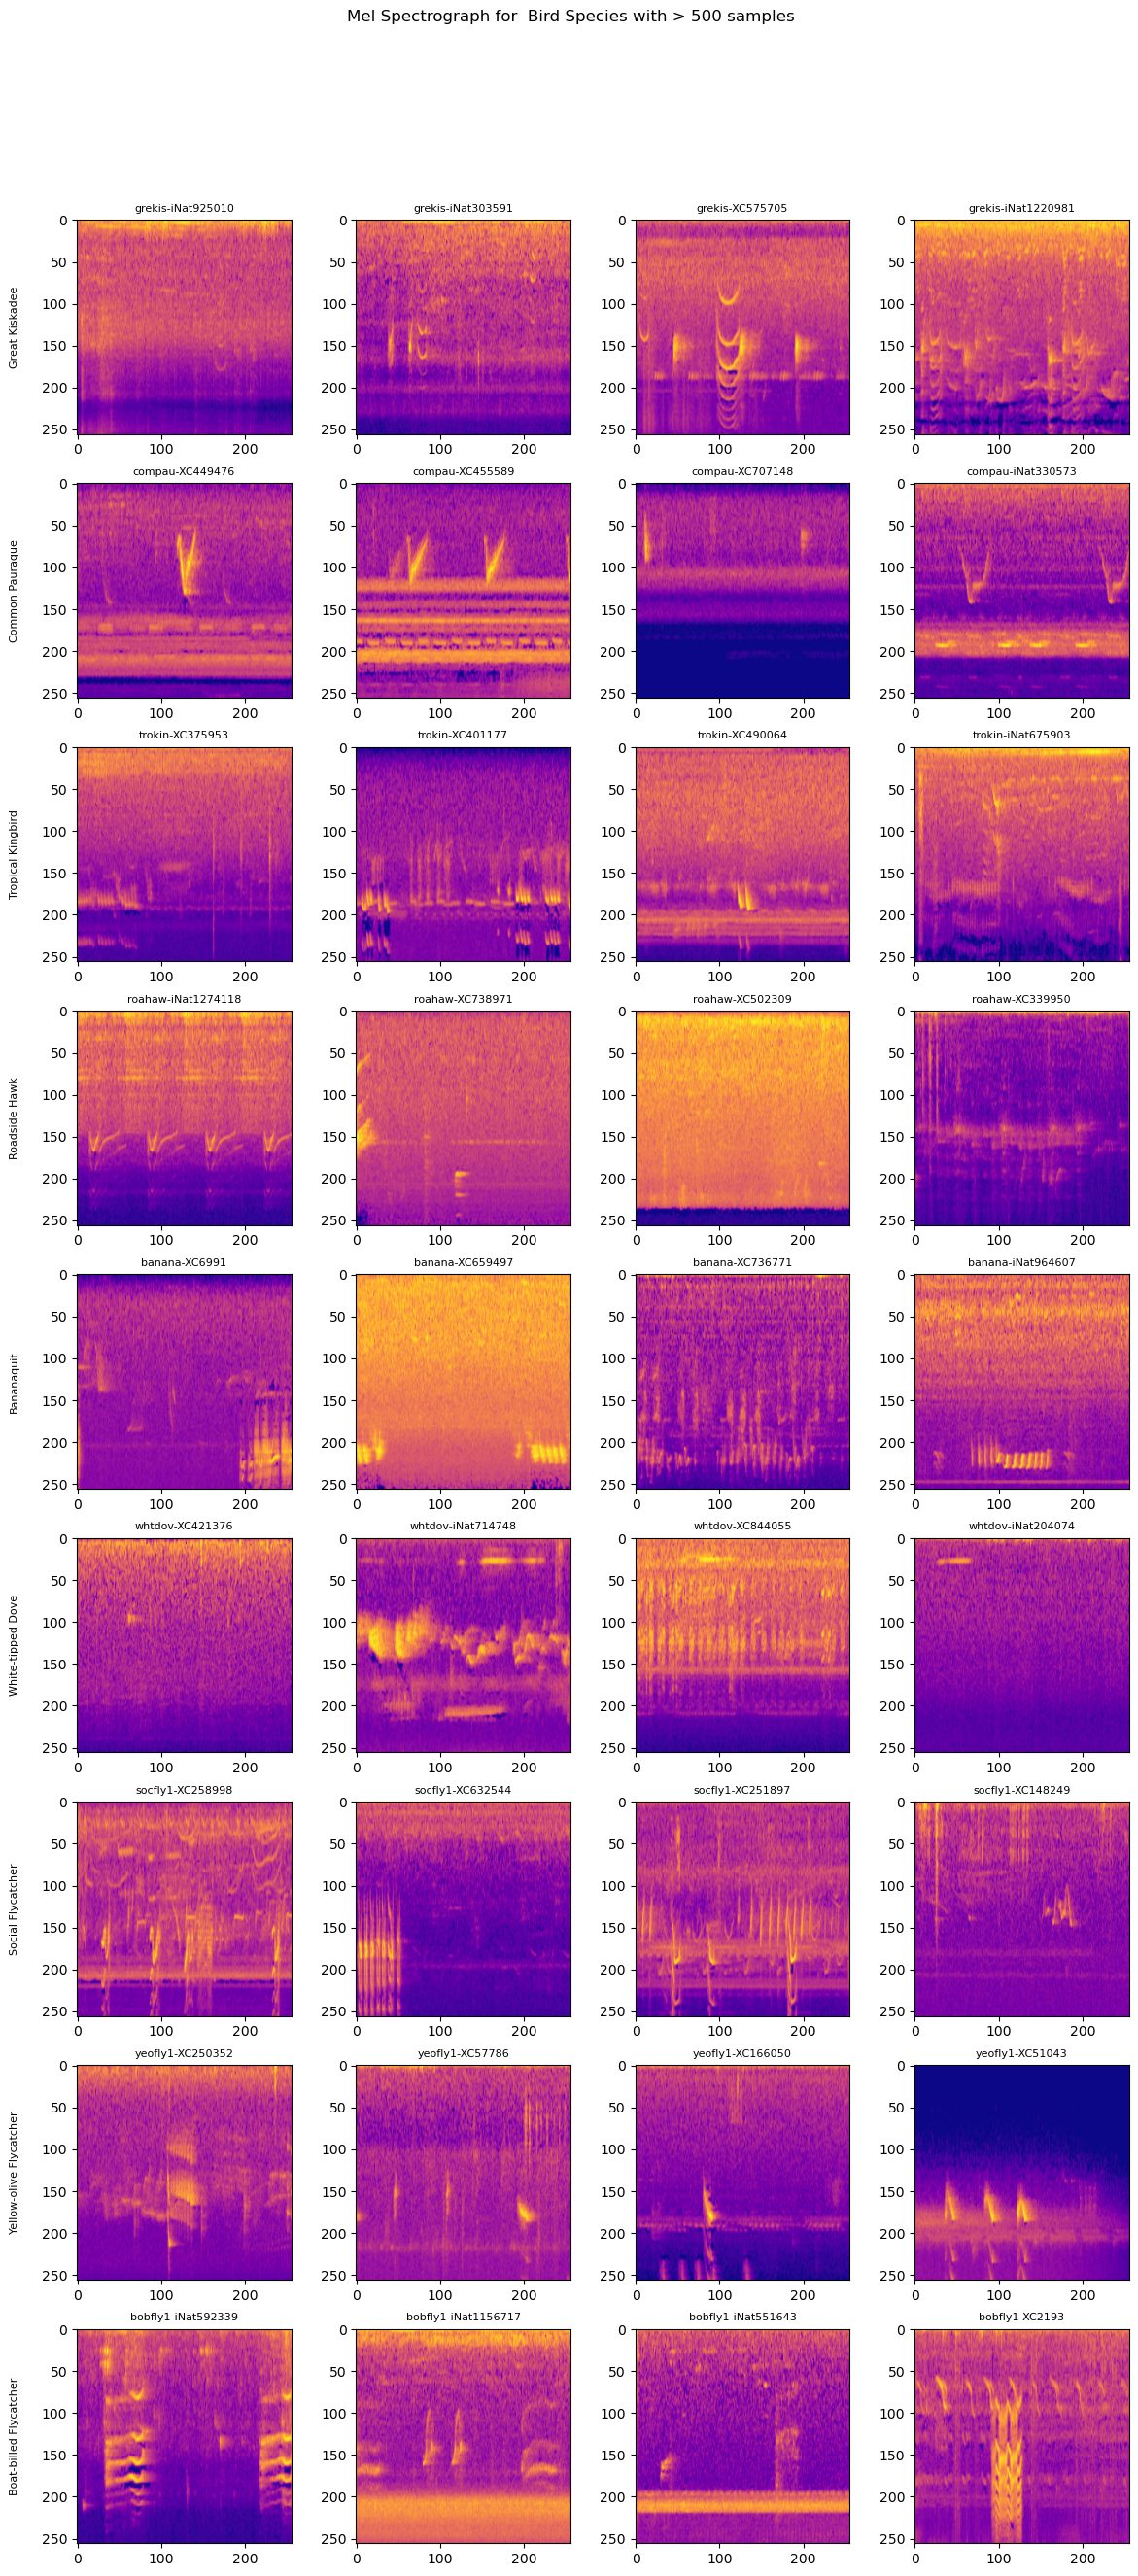

In [7]:
num_labels = len(top_species)
num_images_per_label = 4
fig, axes = plt.subplots(num_labels,num_images_per_label, figsize=(num_images_per_label*3,num_labels*3)) 


for row in np.arange(num_labels):
    keys = species_to_keys.get(top_species[row], [])
    key_list = random.sample(keys, num_images_per_label)
    for col in np.arange(num_images_per_label):
        ax = axes[row,col]
        ax.imshow(graph_dict[key_list[col]],cmap='plasma')
        ax.set_title(key_list[col], fontsize=8)
        if col == 0:
            common_name = list(labels[labels["primary_label"] == top_species[row]]["common_name"])
            #print("common_name:", common_name)
            ax.set_ylabel(common_name[0], fontsize=8, rotation=90, labelpad=20, va='center')
plt.suptitle("Mel Spectrograph for  Bird Species with > 500 samples")  
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

Observations: We observe the images for the same species look quite different and images across different species appear to be similar. Appears to be  difficult task to classifiy these images.

## Reading in data and preparing it for ML

In [ ]:
## Getting data in label/feature format

X = []
y = []

for key, img in graph_dict.items():
    species = key.split('-')[0]
    if species:
        X.append(img)
        y.append(species)

X = np.array(X)
y = np.array(y)

## Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#print(f'X_train shape: {X_train.shape}')
#print(f'Y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'Y_test shape: {y_test.shape}')


## Split training data further into training and validation

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f'X_train shape: {X_train.shape}')
print(f'Y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}')


X_train shape: (22851, 256, 256)
Y_train shape: (22851,)
X_test shape: (5713, 256, 256)
Y_test shape: (5713,)
X_train shape: (22851, 256, 256)
Y_train shape: (22851,)
X_val shape: (5713, 256, 256)
y_val shape: (5713,)


In [10]:
## Flatten to prepare for model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1] * X_val.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])


print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)

## Shuffling the data
np.random.seed(0)
shuffled_indices = np.random.permutation(X_train.shape[0])

X_train = X_train[shuffled_indices]
y_train = y_train[shuffled_indices]





X_train shape: (22851, 65536)
X_val shape: (5713, 65536)
X_test shape: (5713, 65536)


## Baseline model for species

In [ ]:
## Creating a baseline model for species classification
majority_species = top_species[0]

y_train_baseline = (y_train == majority_species).astype(int)

## Building baseline
num_majority_species = np.sum(y_train_baseline == 1)
print(f"Number of samples with {majority_species} species : {num_majority_species}")

num_non_majority_species = np.sum(y_train_baseline== 0)
print(f"Number of samples with non-{majority_species} species: {num_non_majority_species}")

majority_label = 1 if num_majority_species > num_non_majority_species else 0
print(f"Majority label: {majority_label}")

majority_predictions = np.full(y_train_baseline.shape, majority_label)
accuracy = np.mean(majority_predictions == y_train_baseline)
print(f"Accuracy of majority label classifier: {accuracy:.4f}")

def log_loss(y_true, y_pred):
    loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    return loss

#Have to make baseline prediction be non zero so log function can work
baseline_pred = np.ones(y_train_baseline.shape[0])*(majority_label + 0.1 )

train_log_loss = log_loss(y_train_baseline, baseline_pred)
print(f"Log Loss on training data: {train_log_loss:.4f}")


Number of samples with grekis species : 792
Number of samples with non-grekis species: 22059
Majority label: 0
Accuracy of majority label classifier: 0.9653
Log Loss on training data: 0.1815


We observe that baseline model has very high accuracy due to unbalanced data. 

Simple NN model

In [20]:
label_names = labels["primary_label"]
label_encoder = LabelEncoder() # Initialize encoder
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.fit_transform(y_val)
# Flatten Y_train and Y_val, so they become vectors of label values.
y_train = y_train.flatten()
y_val = y_val.flatten()




In [21]:
def build_model(n_classes,
                hidden_layer_sizes=[],
                activation='relu',
                optimizer='SGD',
                learning_rate=0.01,
                metric='metric'):
    """Build a multi-class logistic regression model using Keras.

    Args:
    n_classes: Number of output classes in the dataset.
    hidden_layer_sizes: A list with the number of units in each hidden layer.
    activation: The activation function to use for the hidden layers.
    optimizer: The optimizer to use (SGD, Adam).
    learning_rate: The desired learning rate for the optimizer.
    metric: The desired metric.

    Returns:
    model: A tf.keras model (graph).
    """
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    # YOUR CODE HERE
     # Use Keras Sequential API to build a logistic regression
    model = tf.keras.Sequential()
      
    # create input layer
    num_features = 65536
    model.add(tf.keras.Input(shape=(num_features,), name='Input'))

    # create  hidden layer(s)
    num_hidden_layers = len(hidden_layer_sizes)
    if num_hidden_layers > 0 :
        for i in np.arange(num_hidden_layers):
            model.add(tf.keras.layers.Dense(
                units=hidden_layer_sizes[i],
                activation=activation
            ))


    # create output layer
    model.add(tf.keras.layers.Dense(
        units=n_classes,  #  multiclass classification problem
        use_bias=True,
        activation='softmax', # multiclass classification problem
        kernel_initializer=tf.ones_initializer,  
        bias_initializer=tf.ones_initializer,
        name='Output'
        ))

    # Use Categorical Crossentropy as our loss and the SGD optimizer.
    if optimizer == 'Adam':
        optimizer_obj = tf.keras.optimizers.legacy.Adam(learning_rate)
    else:
        optimizer_obj = tf.keras.optimizers.legacy.SGD(learning_rate) #Default, #legacy for M1/M2 macs

    model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      optimizer=optimizer_obj,  
      metrics=[metric]
      )
    
    print(model.summary())

    return model

In [22]:
def train_and_evaluate( hidden_layer_sizes=[],
                       activation='tanh',
                       optimizer='Adam',
                       learning_rate=0.01,
                       metric='accuracy',
                       num_epochs=10):

  # Build the model.
    model = build_model(n_classes=206,
                      hidden_layer_sizes=hidden_layer_sizes,
                      activation=activation,
                      optimizer=optimizer,
                      metric=metric,
                      learning_rate=learning_rate)

    
  # Train the model.
    print('Training the model...')
    history = model.fit(
        x=X_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=64,
        validation_data=(X_val,y_val),
        verbose=0)

    # Retrieve the training metrics (after each train epoch) and the final validation
    # accuracy.
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    plt.plot(train_accuracy, label='train_accuracy')
    plt.plot(val_accuracy, label='validation accuracy')
    plt.xticks(range(num_epochs))
    plt.xlabel('Train epochs')
    plt.legend()
    plt.show()
    
    print('Training accuracy: %1.4f' %train_accuracy[-1])
    print('Validation accuracy: %1.4f' %val_accuracy[-1])
    
    return model




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Output (Dense)              (None, 206)               13500622  
                                                                 
Total params: 13500622 (51.50 MB)
Trainable params: 13500622 (51.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Training the model...


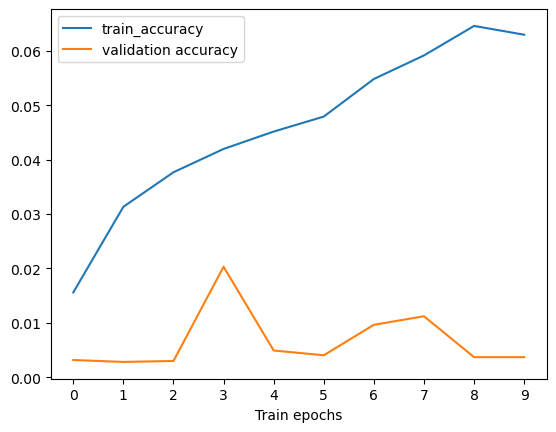

Training accuracy: 0.0630
Validation accuracy: 0.0037


: 

In [ ]:
# run the function
model = train_and_evaluate()

Model has very low accuracy. Need to add additional layers. 